In [1]:
import pandas as pd
import numpy as np
!nvidia-smi
pd.options.display.float_format = '{:,.2f}'.format

Wed Dec 21 21:56:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.05    Driver Version: 510.73.05    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
|  0%   58C    P8    21W / 220W |   7979MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Assign npi based on zip and employer id

In [2]:
in_network_npi_employer = pd.read_csv('employer_in_network.csv', dtype={'npi': str})
def split_npis(row):
    employer_id = row['employer_id']
    npis = row['in_network_npis']    
    npis = npis.split(',')
    result = []
    for npi in npis:
        di = {'employer_id': employer_id, 'npi': npi.strip()}
        result.append(di)
    return result


split_rows = in_network_npi_employer.apply(split_npis, axis=1)
split_rows = [item for sublist in split_rows for item in sublist]
in_network_npi_employer = pd.DataFrame(split_rows)
print(in_network_npi_employer.shape) # (16+16+19)
in_network_npi_employer.describe()

(51, 2)


,employer_id
count,51.00
mean,"67,427.47"
std,"11,336.58"
min,"54,011.00"
25%,"54,011.00"
50%,"69,873.00"
75%,"80,914.00"
max,"80,914.00"


In [3]:
in_network_npi_employer.to_csv('employer_in_network_split.csv')

In [4]:
provider_details = pd.read_csv('providers.csv', dtype={'npi': str, 'zip': str})
print(provider_details.shape)
#drop row with nan in npi column
provider_details = provider_details.dropna(subset=['npi'])
provider_details = provider_details.dropna(subset=['zip'])
print(provider_details.shape)

(23, 3)
(21, 3)


In [5]:
in_network_provider_details = pd.merge(in_network_npi_employer, provider_details, on='npi', how='inner')
print(in_network_provider_details.shape)
# make employer_id as string 
in_network_provider_details['employer_id'] = in_network_provider_details['employer_id'].astype(str)
in_network_provider_details.nunique()

(44, 4)


employer_id       3
npi              20
provider_name    20
zip               5
dtype: int64

In [6]:
# get referrals data
referral_data = pd.read_csv('referrals.csv', dtype={'patient_id': str, 'zip': str, 'gender': str, 'employer_id': str, 'procedure': str, 'cpt': str, 'birth_date': str})
print(referral_data.shape)  

(200, 6)


In [7]:
referral_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   patient_id   200 non-null    object
 1   gender       200 non-null    object
 2   birth_date   200 non-null    object
 3   procedure    200 non-null    object
 4   zip          200 non-null    object
 5   employer_id  200 non-null    object
dtypes: object(6)
memory usage: 9.5+ KB


In [8]:
in_network_provider_details.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44 entries, 0 to 43
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   employer_id    44 non-null     object
 1   npi            44 non-null     object
 2   provider_name  44 non-null     object
 3   zip            44 non-null     object
dtypes: object(4)
memory usage: 1.7+ KB


In [9]:
# merge referral_data  with in_network_provider_details on employer_id and zip
referral_data = pd.merge(referral_data, in_network_provider_details, on=['employer_id', 'zip'], how='inner')

In [10]:
referral_data

,patient_id,gender,birth_date,procedure,zip,employer_id,npi,provider_name
0,13592,female,1950-11-11,29806,349944512,80914,1265415814,"Hill, Nathaniel"
1,13592,female,1950-11-11,29806,349944512,80914,1437132891,"Haas, George"
2,13592,female,1950-11-11,29806,349944512,80914,1225221047,"Kam, Check"
3,13592,female,1950-11-11,29806,349944512,80914,1073757183,"Prasher, Anuj"
4,13592,female,1950-11-11,29806,349944512,80914,1700846227,"Jordan, Steven"
...,...,...,...,...,...,...,...,...
795,13510,male,1961-04-12,27130,334113504,54011,1205818457,"Montijo, Harvey E"
796,13444,male,1952-05-16,27130,334113504,54011,1801878327,"Lins, Robert"
797,13444,male,1952-05-16,27130,334113504,54011,1205818457,"Montijo, Harvey E"
798,13424,female,1950-05-14,27130,334113504,54011,1801878327,"Lins, Robert"


<AxesSubplot:title={'center':'Number of NPIs per patient'}, ylabel='Frequency'>

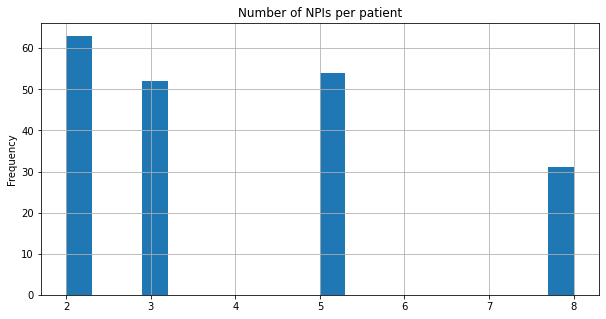

In [11]:
# plot number of npis per patient_id
referral_data.groupby('patient_id')['npi'].count().plot(kind='hist', bins=20, grid=True, figsize=(10, 5), ylabel='Number of patients', xlabel='Number of NPIs', title='Number of NPIs per patient')

## Generate stats for each NPI form encounter_details

### NPI CPT cost

In [12]:
encounter_details = pd.read_csv('encounters_details.csv', dtype={'encounter_id': str, 'npi': str, 'patient_id': str, 'cpt': str, 'paid_amount': float})
print(encounter_details.shape)
encounter_details.head()

(1000, 5)


,encounter_id,npi,patient_id,cpt,paid_amount
0,2AHNOZNX7FGVVZ53CHV45VI6E4======,1285616433,11713,29806,"6,446.00"
1,2A536QLN5SFU25DWXQPGESFUEU======,1285616433,10075,29806,"7,063.00"
2,2ABRCQG5IAYUDM5TL6X45DR6JM======,1285616433,1160,29806,"7,935.00"
3,2A6JXKXJ7OPK2S4VC6735HCMWI======,1285616433,12876,29806,"7,977.00"
4,2A5U2ZQMAESMCULAYSAPZJXRSY======,1285616433,1027,29806,"8,772.00"


In [13]:
npi_cpt_cost = encounter_details.groupby(['npi', 'cpt'])['paid_amount'].mean().round(2).reset_index()
print(npi_cpt_cost.shape)
# rename paid_amount to cost
npi_cpt_cost = npi_cpt_cost.rename(columns={'paid_amount': 'cost'})
npi_cpt_cost

(112, 3)


,npi,cpt,cost
0,1063494227,20610,441.00
1,1063494227,24538,"6,953.33"
2,1063494227,27130,863.00
3,1063494227,29806,"17,406.33"
4,1063494227,29888,"7,330.00"
...,...,...,...
107,1992787402,20610,294.00
108,1992787402,24538,"2,432.46"
109,1992787402,27130,"1,905.08"
110,1992787402,29806,"10,672.00"


In [14]:
# find no of npi in referral_data not present in npi_cpt_cost
# there are 7 npi that we cannot recommend from encounter_details
npi_cpt_cost[~npi_cpt_cost['npi'].isin(referral_data['npi'])]['npi'].nunique()

7

In [15]:
# find cpt in referral_data not present in npi_cpt_cost
npi_cpt_cost[~npi_cpt_cost['cpt'].isin(referral_data['procedure'])]['cpt'].nunique()

0

### Quality Calculation for each NPI

In [16]:
# count num of cpts per npi  in encounter_details
# encounter_details.groupby(['npi', 'cpt'])['patient_id'].count().sort_values(ascending=False)
npi_cpt_count = encounter_details.groupby(['npi', 'cpt'])['patient_id'].count().reset_index().rename(columns={'patient_id': 'patient_count'})
npi_cpt_count

,npi,cpt,patient_count
0,1063494227,20610,2
1,1063494227,24538,3
2,1063494227,27130,1
3,1063494227,29806,3
4,1063494227,29888,4
...,...,...,...
107,1992787402,20610,6
108,1992787402,24538,13
109,1992787402,27130,13
110,1992787402,29806,10


In [17]:
cpt_patient_count = encounter_details.groupby('cpt')['patient_id'].count().reset_index().rename(columns={'patient_id': 'total_patient_count'})
cpt_npi_count = encounter_details.groupby('cpt')['npi'].nunique().reset_index().rename(columns={'npi': 'npi_count'})
cpt_npi_patient_counts = pd.merge(cpt_npi_count, cpt_patient_count, on='cpt', how='inner')

In [18]:
# add new column to avg_patient_count_per_npi
cpt_npi_patient_counts['avg_patient_count_per_npi'] = np.floor(cpt_npi_patient_counts['total_patient_count'] / cpt_npi_patient_counts['npi_count'])
cpt_npi_patient_counts = cpt_npi_patient_counts.drop(columns=['npi_count', 'total_patient_count'])
cpt_npi_patient_counts

,cpt,avg_patient_count_per_npi
0,20610,4.00
1,24538,8.00
2,27130,12.00
3,29806,8.00
4,29888,9.00


In [19]:
# merge npi_cpt_count with cpt_npi_patient_counts on cpt
npi_cpt_count = pd.merge(npi_cpt_count, cpt_npi_patient_counts, on='cpt', how='inner')
npi_cpt_count


,npi,cpt,patient_count,avg_patient_count_per_npi
0,1063494227,20610,2,4.00
1,1073757183,20610,7,4.00
2,1174543573,20610,4,4.00
3,1205818457,20610,3,4.00
4,1225221047,20610,2,4.00
...,...,...,...,...
107,1801878327,29888,15,9.00
108,1861499451,29888,3,9.00
109,1902012800,29888,6,9.00
110,1902020159,29888,3,9.00


In [20]:
# merge npi_cpt_count with npi_cpt_cost on npi and cpt
npi_cpt_cost_quality = pd.merge(npi_cpt_count, npi_cpt_cost, on=['npi', 'cpt'], how='inner')
npi_cpt_cost_quality

,npi,cpt,patient_count,avg_patient_count_per_npi,cost
0,1063494227,20610,2,4.00,441.00
1,1073757183,20610,7,4.00,417.43
2,1174543573,20610,4,4.00,307.25
3,1205818457,20610,3,4.00,275.00
4,1225221047,20610,2,4.00,294.00
...,...,...,...,...,...
107,1801878327,29888,15,9.00,"10,219.60"
108,1861499451,29888,3,9.00,"5,660.33"
109,1902012800,29888,6,9.00,"11,781.33"
110,1902020159,29888,3,9.00,"7,360.67"


In [21]:
# add new column quality = 1 if patient_count > avg_patient_count_per_npi else 0
npi_cpt_cost_quality['quality'] = npi_cpt_cost_quality['patient_count'] - npi_cpt_cost_quality['avg_patient_count_per_npi']
npi_cpt_cost_quality.quality.value_counts()

-2.00     15
-3.00     10
-5.00      9
-4.00      9
0.00       8
2.00       8
-6.00      7
3.00       6
5.00       4
4.00       4
-1.00      4
1.00       3
-7.00      3
6.00       3
7.00       2
8.00       2
17.00      2
12.00      2
-11.00     2
9.00       2
-10.00     1
31.00      1
24.00      1
15.00      1
13.00      1
23.00      1
10.00      1
Name: quality, dtype: int64

In [22]:
# add new column capacity = np.ceil(patient_count / 2)
npi_cpt_cost_quality['capacity'] = np.ceil(npi_cpt_cost_quality['patient_count'] / 2)
npi_cpt_cost_quality

,npi,cpt,patient_count,avg_patient_count_per_npi,cost,quality,capacity
0,1063494227,20610,2,4.00,441.00,-2.00,1.00
1,1073757183,20610,7,4.00,417.43,3.00,4.00
2,1174543573,20610,4,4.00,307.25,0.00,2.00
3,1205818457,20610,3,4.00,275.00,-1.00,2.00
4,1225221047,20610,2,4.00,294.00,-2.00,1.00
...,...,...,...,...,...,...,...
107,1801878327,29888,15,9.00,"10,219.60",6.00,8.00
108,1861499451,29888,3,9.00,"5,660.33",-6.00,2.00
109,1902012800,29888,6,9.00,"11,781.33",-3.00,3.00
110,1902020159,29888,3,9.00,"7,360.67",-6.00,2.00


## Final NPI Stats

In [23]:
npi_stats = npi_cpt_cost_quality

In [24]:
npi_stats

,npi,cpt,patient_count,avg_patient_count_per_npi,cost,quality,capacity
0,1063494227,20610,2,4.00,441.00,-2.00,1.00
1,1073757183,20610,7,4.00,417.43,3.00,4.00
2,1174543573,20610,4,4.00,307.25,0.00,2.00
3,1205818457,20610,3,4.00,275.00,-1.00,2.00
4,1225221047,20610,2,4.00,294.00,-2.00,1.00
...,...,...,...,...,...,...,...
107,1801878327,29888,15,9.00,"10,219.60",6.00,8.00
108,1861499451,29888,3,9.00,"5,660.33",-6.00,2.00
109,1902012800,29888,6,9.00,"11,781.33",-3.00,3.00
110,1902020159,29888,3,9.00,"7,360.67",-6.00,2.00


## Combine NPI stats with referral data

In [25]:
# join npi_stats with referral_data, on npi and procedure in referral_data and npi and cpt in npi_stats
patients_with_docs_stats = referral_data.merge(npi_stats, left_on=['npi', 'procedure'], right_on=['npi', 'cpt'], how='left')

In [26]:
patients_with_docs_stats

,patient_id,gender,birth_date,procedure,zip,employer_id,npi,provider_name,cpt,patient_count,avg_patient_count_per_npi,cost,quality,capacity
0,13592,female,1950-11-11,29806,349944512,80914,1265415814,"Hill, Nathaniel",29806,5.00,8.00,"11,525.60",-3.00,3.00
1,13592,female,1950-11-11,29806,349944512,80914,1437132891,"Haas, George",29806,8.00,8.00,"11,274.25",0.00,4.00
2,13592,female,1950-11-11,29806,349944512,80914,1225221047,"Kam, Check",29806,3.00,8.00,"13,425.00",-5.00,2.00
3,13592,female,1950-11-11,29806,349944512,80914,1073757183,"Prasher, Anuj",29806,25.00,8.00,"19,032.88",17.00,13.00
4,13592,female,1950-11-11,29806,349944512,80914,1700846227,"Jordan, Steven",29806,6.00,8.00,"22,645.83",-2.00,3.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,13510,male,1961-04-12,27130,334113504,54011,1205818457,"Montijo, Harvey E",27130,5.00,12.00,"1,965.40",-7.00,3.00
796,13444,male,1952-05-16,27130,334113504,54011,1801878327,"Lins, Robert",27130,15.00,12.00,"2,527.53",3.00,8.00
797,13444,male,1952-05-16,27130,334113504,54011,1205818457,"Montijo, Harvey E",27130,5.00,12.00,"1,965.40",-7.00,3.00
798,13424,female,1950-05-14,27130,334113504,54011,1801878327,"Lins, Robert",27130,15.00,12.00,"2,527.53",3.00,8.00


In [27]:
(patients_with_docs_stats['quality'] >= 0).sum()

325

In [28]:
patients_with_docs_stats.groupby('patient_id')['npi'].count().sort_values(ascending=True)

patient_id
13400    2
13535    2
13456    2
13454    2
13453    2
        ..
13508    8
13563    8
13479    8
13426    8
13490    8
Name: npi, Length: 200, dtype: int64

In [29]:
# get columns 'npi', 'cpt', 'count' form npi_cpt_count
over_all_capacity = npi_cpt_count[['npi', 'cpt', 'patient_count']]
# add new column capacity = np.ceil(patient_count / 2)
over_all_capacity['capacity'] = np.ceil(over_all_capacity['patient_count'] / 2)
over_all_capacity


,npi,cpt,patient_count,capacity
0,1063494227,20610,2,1.00
1,1073757183,20610,7,4.00
2,1174543573,20610,4,2.00
3,1205818457,20610,3,2.00
4,1225221047,20610,2,1.00
...,...,...,...,...
107,1801878327,29888,15,8.00
108,1861499451,29888,3,2.00
109,1902012800,29888,6,3.00
110,1902020159,29888,3,2.00


# (Quality, cost) based allocation 

In [30]:
# convert over_all_capacity to dict with key as (npi, cpt) and value as capacity
over_all_capacity_dict = over_all_capacity.set_index(['npi', 'cpt'])['capacity'].to_dict()
# get all unique npi providers
npi_list = over_all_capacity['npi'].unique()
# get all cpt from referral_data
cpt_list = referral_data['procedure'].unique()
# combine npi and cpt to get all possible combinations in a dict with key as (npi, cpt) and value as 1
all_possible_combinations = {(npi, cpt): 1 for npi in npi_list for cpt in cpt_list}
# merge over_all_capacity_dict and all_possible_combinations to get a dict with key as (npi, cpt) and value as capacity
for key, value in all_possible_combinations.items():
    if key in over_all_capacity_dict:
        over_all_capacity_dict[key] = over_all_capacity_dict[key] + value

In [31]:
assigned_npi = {}
missed_patients = []
cpts_with_no_npi = []
zips = []

patient_with_possible_npi = patients_with_docs_stats.groupby('patient_id')['npi', 'cpt', 'quality', 'cost'].apply(lambda x: x.values.tolist()).to_dict()
for patient, npis in patient_with_possible_npi.items():
    # sort npis by quality in descending order and cost in ascending order
    npis.sort(key=lambda x: (x[2], -x[3]), reverse=True)
    # get the first npi with capacity > 0
    
    for npi in npis:
        # print(type(npi[1]), npi[1], )
        if type(npi[1]) == str and over_all_capacity_dict[(npi[0], npi[1])] > 0:
            over_all_capacity_dict[(npi[0], npi[1])] = over_all_capacity_dict[(npi[0], npi[1])] - 1
            assigned_npi[patient] = npi
            break
    else:
        missed_patients.append(patient)
        cpts_with_no_npi.append(npis[0][1])
        zips.append(patients_with_docs_stats[patients_with_docs_stats['patient_id'] == patient]['zip'].values[0])
        # print("-----------------")
        # print('No npi found for patient', patient)
        # for npi in npis:
        #     if type(npi[1]) == str:
        #         print(npi, over_all_capacity_dict[(npi[0], npi[1])])
        # print("-----------------")

/tmp/ipykernel_1046664/3147517583.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  patient_with_possible_npi = patients_with_docs_stats.groupby('patient_id')['npi', 'cpt', 'quality', 'cost'].apply(lambda x: x.values.tolist()).to_dict()


In [32]:
# count no of times each cpt occurs in cpts_with_no_npi
from collections import Counter
print(Counter(cpts_with_no_npi))
set(Counter(zips))

Counter({'29888': 8, '24538': 6, '29806': 6, '27130': 4})


{'334113504'}

In [33]:
# convert assigned_npi to dataframe with key and values as columns
assigned_npi_df = pd.DataFrame.from_dict(assigned_npi, orient='index', columns=['npi', 'cpt', 'quality', 'cost'])

In [34]:
print(assigned_npi_df['npi'].nunique())
print(assigned_npi_df.shape)

9
(176, 4)


In [ ]:
# Final Allocation
assigned_npi_df

,npi,cpt,quality,cost
13400,1801878327,24538,5.00,"3,459.46"
13401,1801878327,29806,4.00,"10,177.17"
13402,1073757183,27130,31.00,"1,840.81"
13403,1801878327,29806,4.00,"10,177.17"
13404,1801878327,29806,4.00,"10,177.17"
...,...,...,...,...
13593,1063494227,20610,-2.00,441.00
13594,1467490763,24538,12.00,"3,131.90"
13596,1437132891,29888,3.00,"8,651.42"
13597,1437132891,29806,0.00,"11,274.25"


Note: We are not allocating npi for all patients that is because we are making sure the doctors are not exceeding there capaciy